In [42]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go

In [43]:
from constants import EQ, HH, custom_tech_colors, custom_metal_colors

In [44]:
# Save to csv to the result folder
df_sps_damage = pd.read_csv(r'results/df_sps_damage_regionalized.csv')
df_nze_damage = pd.read_csv(r'results/df_nze_damage_regionalized.csv')

In [45]:
from matplotlib import rcParams

# Set global Matplotlib parameters
rcParams['pdf.fonttype'] = 42  # Ensure TrueType fonts are embedded
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'  # Use serif fonts like Times New Roman or Palatino
rcParams['font.size'] = 10
rcParams['axes.labelsize'] = 10
rcParams['legend.fontsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['axes.titlesize'] = 12

## Stacked bar from 2022 to 2050 for metals and technologies

In [46]:
def plot_stacked_area(df, group_by, value_col, title, y_label, color_palette="tab20", custom_colors=None, threshold=0.01, save_path="plots/stacked_area"):
    """
    Generate a stacked area plot with optional custom colors and conditional aggregation.

    Parameters:
    - df: DataFrame with data
    - group_by: Column to group by ('Metal' or 'Technology')
    - value_col: Column containing impact values
    - title: Plot title
    - y_label: Label for Y-axis (e.g., "Impact (unit)")
    - color_palette: Colormap name for automatic coloring (default: "tab20")
    - custom_colors: Dict with manual colors (e.g., {"Solar PV": "#1f77b4"})
    - threshold: Threshold for grouping small categories into "Other" (applies only to Metals, not Technologies)
    - save_path: Base filename for saving plots (without extension)
    
    Outputs:
    - Saves PDF and PNG versions of the figure
    """

    # Ensure directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Aggregate data
    df_grouped = df.groupby(["Year", group_by])[value_col].sum().reset_index()

    # Apply threshold only for Metals, keep all Technologies
    if group_by == "Metal":
        total_contributions = df_grouped.groupby(group_by)[value_col].sum()
        significant_categories = total_contributions[total_contributions / total_contributions.sum() >= threshold].index
        df_grouped[group_by] = df_grouped[group_by].apply(lambda x: x if x in significant_categories else "Other")

    # Pivot for stacked area plot
    df_pivot = df_grouped.pivot_table(index="Year", columns=group_by, values=value_col, aggfunc="sum")

    # Sort categories based on first year's contribution (largest to smallest)
    first_year = df_pivot.index.min()
    sorted_categories = df_pivot.loc[first_year].sort_values(ascending=False).index
    df_pivot = df_pivot[sorted_categories]

    # Assign colors (Fix: Apply to both Metals & Technologies)
    unique_categories = df_pivot.columns
    if custom_colors:
        # Apply user-defined colors for both Metals & Technologies
        color_dict = {cat: custom_colors.get(cat, "gray") for cat in unique_categories}
    else:
        # Otherwise, use colormap
        cmap = cm.get_cmap(color_palette, len(unique_categories))
        color_dict = {cat: cmap(i) for i, cat in enumerate(unique_categories)}

    # Generate plot
    fig, ax = plt.subplots(figsize=(7.2, 4.5))
    colors = [color_dict.get(col, "gray") for col in df_pivot.columns]
    ax.stackplot(df_pivot.index, df_pivot.T, labels=df_pivot.columns, colors=colors, alpha=0.8)

    # Formatting
    ax.set_title(title)
    ax.set_ylabel(y_label)

    # Sort legend in the same order as the stacked areas
    handles, labels = ax.get_legend_handles_labels()
    legend_order = [labels.index(cat) for cat in sorted_categories if cat in labels]
    sorted_handles = [handles[i] for i in legend_order]
    sorted_labels = [labels[i] for i in legend_order]

    ax.legend(sorted_handles, sorted_labels, loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()

    # Save figures
    plt.savefig(f"{save_path}.pdf", format="pdf", dpi=600, transparent=True)
    plt.savefig(f"{save_path}.png", format="png", dpi=600)
    plt.show()


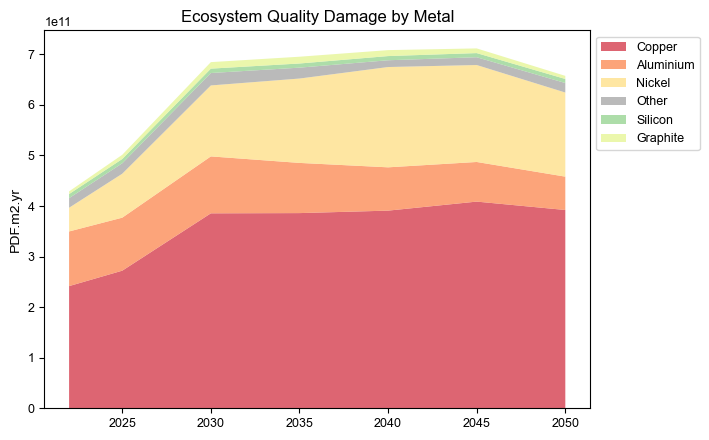

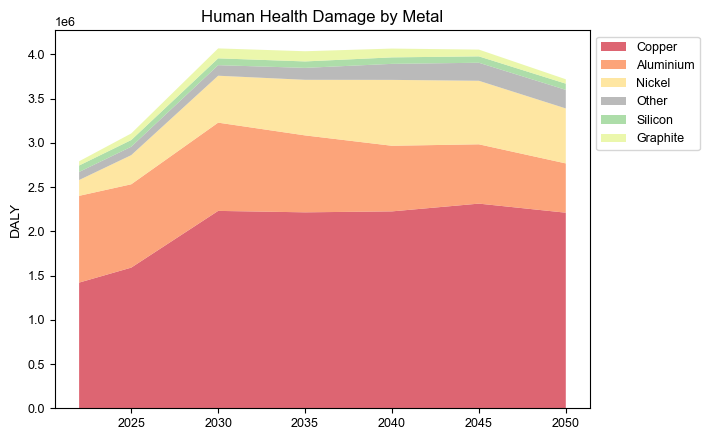

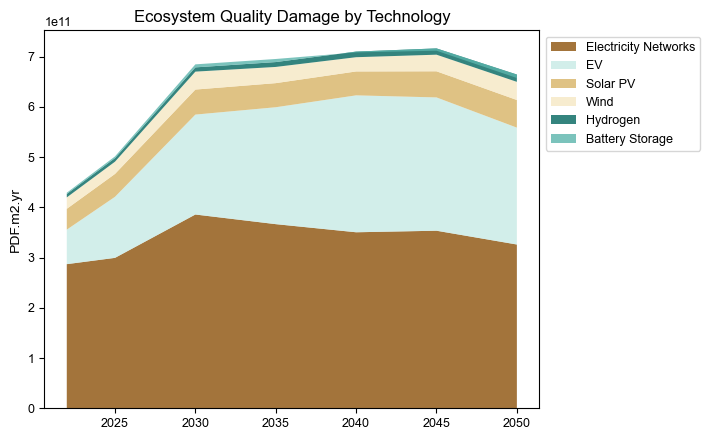

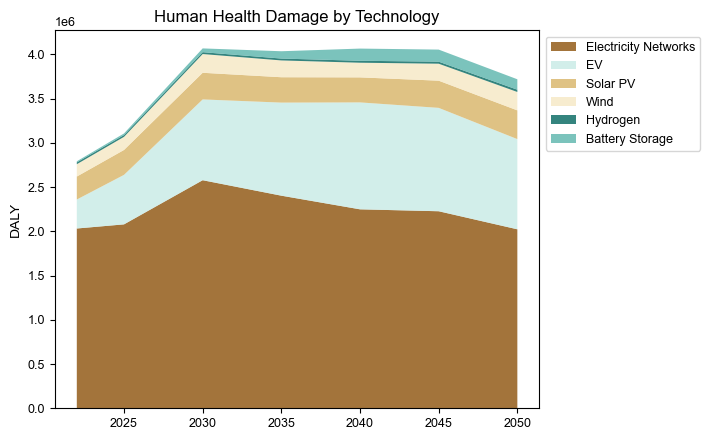

In [47]:
# Generate plots
fig_sps_metal_eq = plot_stacked_area(df_sps_damage, "Metal", "Total ecosystem quality", "Ecosystem Quality Damage by Metal", "PDF.m2.yr", custom_colors=custom_metal_colors, save_path="results/plots/stacked_area_metals_technologies/fig_sps_metal_eq")
fig_sps_metal_hh = plot_stacked_area(df_sps_damage, "Metal", "Total human health", "Human Health Damage by Metal", "DALY", custom_colors=custom_metal_colors, save_path="results/plots/stacked_area_metals_technologies/fig_sps_metal_hh")
fig_sps_tech_eq = plot_stacked_area(df_sps_damage, "Technology", "Total ecosystem quality", "Ecosystem Quality Damage by Technology", "PDF.m2.yr", custom_colors=custom_tech_colors, save_path="results/plots/stacked_area_metals_technologies/fig_sps_tech_eq")
fig_sps_tech_hh = plot_stacked_area(df_sps_damage, "Technology", "Total human health", "Human Health Damage by Technology", "DALY", custom_colors=custom_tech_colors, save_path="results/plots/stacked_area_metals_technologies/fig_sps_tech_hh")

## Stacked barplot for MP contribution per year

In [48]:
def generate_full_color_dict(impact_categories, custom_colors, colormap="tab20"):
    """
    Ensures all impact categories receive a distinct color.
    
    - Uses predefined colors for important categories.
    - Assigns unique colors to remaining categories from a colormap.

    Parameters:
    - impact_categories: List of all impact categories
    - custom_colors: Dictionary of manually defined colors for key categories
    - colormap: Matplotlib colormap to use for additional categories
    
    Returns:
    - A complete color dictionary for all impact categories
    """
    
    # Get a colormap with enough distinct colors
    cmap = cm.get_cmap(colormap, len(impact_categories))

    # Start with predefined colors
    full_color_dict = custom_colors.copy()

    # Assign unique colors to missing categories
    for i, cat in enumerate(impact_categories):
        if cat not in full_color_dict:
            full_color_dict[cat] = cmap(i)  # Assign a unique color

    return full_color_dict

def plot_stacked_bar(df, impact_columns, total_col, title, y_label="Percentage contribution (%)", 
                     color_palette="tab20", custom_colors=None, threshold=0.03, save_path="plots/stacked_bar"):
    """
    Generate a stacked bar plot showing the contribution of different midpoint indicators to the total impact.
    Contributors below a threshold (default: 5%) are grouped into "Other".

    Parameters:
    - df: DataFrame with data
    - impact_columns: List of midpoint impact indicators (e.g., EQ or HH categories)
    - total_col: Column containing the total impact for normalization (e.g., 'Total ecosystem quality' or 'Total human health')
    - title: Plot title
    - y_label: Label for Y-axis (default: "Percentage contribution (%)")
    - color_palette: Colormap name for automatic coloring (default: "tab20") if no custom colors are provided
    - custom_colors: Dictionary with predefined colors for certain categories
    - threshold: Minimum percentage contribution to remain separate; others are grouped into "Other"
    - save_path: Base filename for saving plots (without extension)
    
    Outputs:
    - Saves PDF and PNG versions of the figure
    """

    # Ensure directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Aggregate data by year
    df_grouped = df.groupby("Year")[impact_columns + [total_col]].sum()

    # Convert to percentage of total impact
    df_percent = df_grouped[impact_columns].div(df_grouped[total_col], axis=0) * 100

    # Identify small contributors to group into "Other"
    total_contributions = df_percent.mean()  # Average over time for consistency
    significant_categories = total_contributions[total_contributions >= (threshold * 100)].index.tolist()
    
    # Group small contributors into "Other"
    df_percent["Other"] = df_percent.drop(columns=significant_categories).sum(axis=1)
    df_percent = df_percent[significant_categories + ["Other"]]

    # Sort categories based on first year's contribution (largest to smallest)
    first_year = df_percent.index.min()
    sorted_categories = df_percent.loc[first_year].sort_values(ascending=False).index
    df_percent = df_percent[sorted_categories]

    # Assign colors: use custom colors if provided, else use a colormap
    if custom_colors:
        color_dict = {cat: custom_colors.get(cat, "gray") for cat in sorted_categories}
    else:
        color_dict = generate_full_color_dict(sorted_categories, {}, color_palette)

    # Ensure "Other" has a distinct neutral color
    color_dict["Other"] = "#2b2d42"  # Dark Gray for clarity

    # Generate plot
    fig, ax = plt.subplots(figsize=(7.2, 5))
    colors = [color_dict[col] for col in df_percent.columns]
    df_percent.plot(kind="bar", stacked=True, color=colors, ax=ax, width=0.8)

    # Formatting
    ax.set_title(title, fontsize=12)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_xlabel("")
    ax.set_xticklabels(df_percent.index, rotation=360)

    # Legend formatting: Reduce size, place below if necessary
    #ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=6, frameon=False)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8, frameon=False)


    plt.tight_layout()

    # Save figures
    plt.savefig(f"{save_path}.pdf", format="pdf", dpi=600)
    plt.savefig(f"{save_path}.png", format="png", dpi=600)
    plt.show()


In [49]:
# Define the directory for saving bar plots
barplot_dir = "results/plots/stacked_barplots_mp_contribution"
os.makedirs(barplot_dir, exist_ok=True)

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_2752\2719915546.py:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



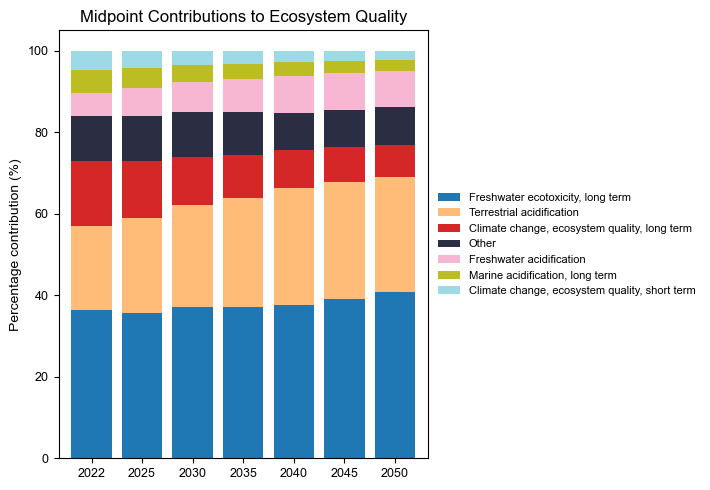

In [50]:
fig_sps_mp_eq = plot_stacked_bar(df_sps_damage, EQ, "Total ecosystem quality",
                 "Midpoint Contributions to Ecosystem Quality",
                 custom_colors=None,
                 save_path=f"{barplot_dir}/fig_sps_mp_eq")

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_2752\2719915546.py:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



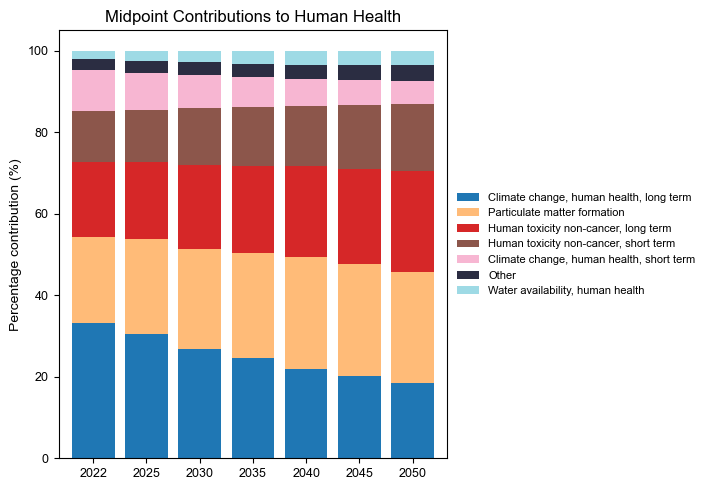

In [51]:
fig_sps_mp_hh = plot_stacked_bar(df_sps_damage, HH, "Total human health", 
                                 "Midpoint Contributions to Human Health", 
                                 custom_colors=None,
                                 save_path=f"{barplot_dir}/fig_sps_mp_hh")

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_2752\2719915546.py:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



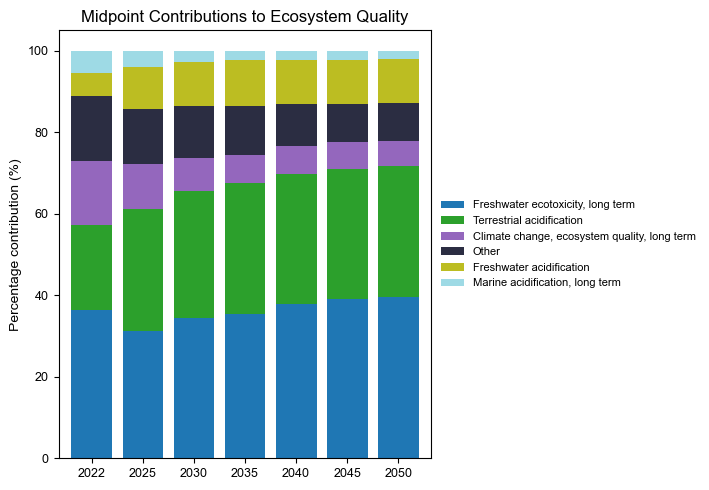

In [52]:
fig_nze_mp_eq = plot_stacked_bar(df_nze_damage, EQ, "Total ecosystem quality",
                 "Midpoint Contributions to Ecosystem Quality", 
                 custom_colors=None,
                 save_path=f"{barplot_dir}/fig_nze_mp_eq")

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_2752\2719915546.py:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



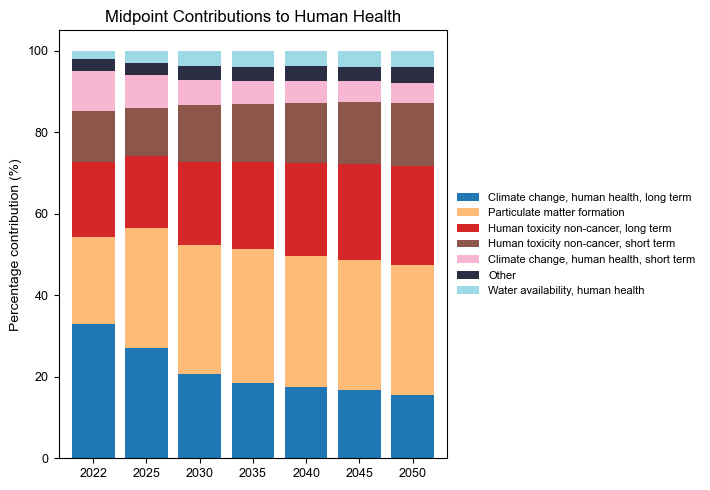

In [53]:
fig_nze_mp_hh = plot_stacked_bar(df_nze_damage, HH, "Total human health", 
                                 "Midpoint Contributions to Human Health",
                                 custom_colors=None,
                                 save_path=f"{barplot_dir}/fig_nze_mp_hh")

## Barplot for MP contribution over the period

In [54]:
def plot_cumulative_midpoint_contribution(df, impact_columns, total_col, title, y_label="Percentage contribution (%)", 
                                          color_palette="tab20", custom_colors=None, threshold=0.03, 
                                          save_path="plots/cumulative_midpoint"):
    """
    Generate a bar plot showing the cumulative contribution of different midpoint indicators to the total impact from 2022-2050.
    Bars represent the mean contribution, with a line showing min-max variation. Contributors below a threshold (default: 5%) 
    are grouped into "Other".

    Parameters:
    - df: DataFrame with data
    - impact_columns: List of midpoint impact indicators (e.g., EQ or HH categories)
    - total_col: Column containing the total impact for normalization (e.g., 'Total ecosystem quality' or 'Total human health')
    - title: Plot title
    - y_label: Label for Y-axis (default: "Percentage contribution (%)")
    - color_palette: Colormap name for automatic coloring (default: "tab20") if no custom colors are provided
    - custom_colors: Dictionary with predefined colors for certain categories
    - threshold: Minimum percentage contribution to remain separate; others are grouped into "Other"
    - save_path: Base filename for saving plots (without extension)
    
    Outputs:
    - Saves PDF and PNG versions of the figure
    """

    # Ensure directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Aggregate data over all years (2022-2050)
    df_grouped = df.groupby("Year")[impact_columns + [total_col]].sum()

    # Convert to percentage of total impact
    df_percent = df_grouped[impact_columns].div(df_grouped[total_col], axis=0) * 100

    # Compute mean, min, and max contributions over time
    mean_contributions = df_percent.mean()
    min_contributions = df_percent.min()
    max_contributions = df_percent.max()

    # Identify small contributors to group into "Other"
    significant_categories = mean_contributions[mean_contributions >= (threshold * 100)].index.tolist()
    
    # Group small contributors into "Other"
    df_percent["Other"] = df_percent.drop(columns=significant_categories).sum(axis=1)
    mean_contributions["Other"] = df_percent["Other"].mean()
    min_contributions["Other"] = df_percent["Other"].min()
    max_contributions["Other"] = df_percent["Other"].max()

    # Keep only significant contributors + "Other"
    mean_contributions = mean_contributions[significant_categories + ["Other"]]
    min_contributions = min_contributions[significant_categories + ["Other"]]
    max_contributions = max_contributions[significant_categories + ["Other"]]

    # Sort categories by mean contribution
    sorted_categories = mean_contributions.sort_values(ascending=False).index
    mean_contributions = mean_contributions[sorted_categories]
    min_contributions = min_contributions[sorted_categories]
    max_contributions = max_contributions[sorted_categories]

    # Assign colors: use custom colors if provided, else use a colormap
    if custom_colors:
        color_dict = {cat: custom_colors.get(cat, "gray") for cat in sorted_categories}
    else:
        cmap = cm.get_cmap(color_palette, len(sorted_categories))
        color_dict = {cat: cmap(i) for i, cat in enumerate(sorted_categories)}

    # Ensure "Other" has a distinct neutral color
    color_dict["Other"] = "#A9A9A9"  # Dark Gray for clarity

    # Generate plot
    fig, ax = plt.subplots(figsize=(9, 5))
    x_positions = np.arange(len(sorted_categories))
    colors = [color_dict[col] for col in sorted_categories]

    # Plot bars (mean values)
    bars = ax.bar(x_positions, mean_contributions, color=colors, alpha=0.8)

    # Add min-max variation as a line
    ax.errorbar(x_positions, mean_contributions, 
                yerr=[mean_contributions - min_contributions, max_contributions - mean_contributions], 
                fmt='none', ecolor='black', capsize=4, elinewidth=1)

    # Formatting
    ax.set_title(title, fontsize=12)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(sorted_categories, rotation=90, ha="right", fontsize=8)

    # Save figures
    plt.tight_layout()
    plt.savefig(f"{save_path}.pdf", format="pdf", dpi=600)
    plt.savefig(f"{save_path}.png", format="png", dpi=600)
    plt.show()

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_2752\2088166210.py:62: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



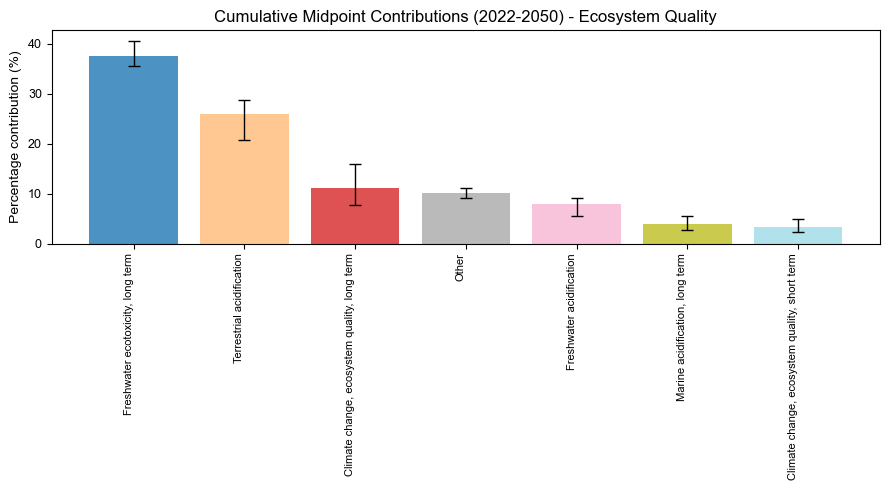

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_2752\2088166210.py:62: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



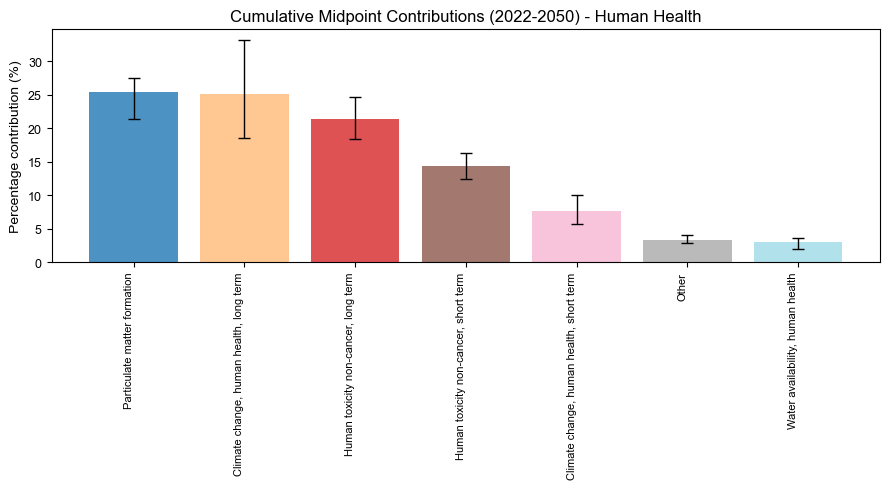

In [55]:
fig_sps_mp_eq_cum = plot_cumulative_midpoint_contribution(df_sps_damage, EQ, "Total ecosystem quality",
                                      "Cumulative Midpoint Contributions (2022-2050) - Ecosystem Quality",
                                      save_path="results/plots/barplots_mp_contribution_cumulative/fig_sps_mp_eq_cum")

fig_sps_mp_hh_cum = plot_cumulative_midpoint_contribution(df_sps_damage, HH, "Total human health",
                                      "Cumulative Midpoint Contributions (2022-2050) - Human Health",
                                      save_path="results/plots/barplots_mp_contribution_cumulative/fig_sps_mp_hh_cum")


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_2752\2088166210.py:62: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



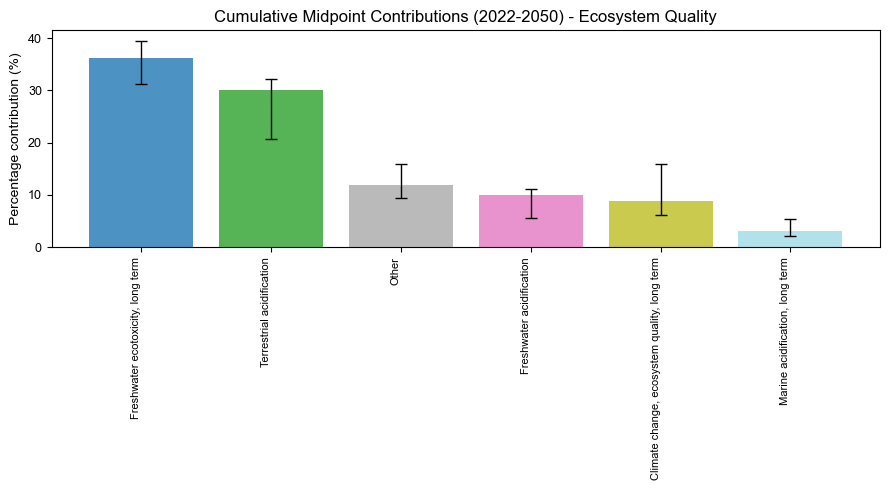

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_2752\2088166210.py:62: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



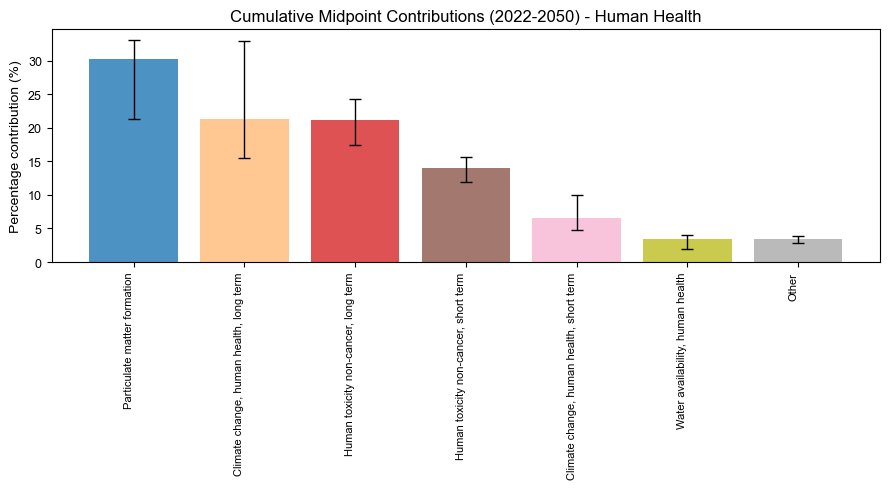

In [56]:
fig_nze_mp_eq_cum = plot_cumulative_midpoint_contribution(df_nze_damage, EQ, "Total ecosystem quality",
                                      "Cumulative Midpoint Contributions (2022-2050) - Ecosystem Quality",
                                      save_path="results/plots/barplots_mp_contribution_cumulative/fig_nze_mp_eq_cum")

fig_nze_mp_hh_cum = plot_cumulative_midpoint_contribution(df_nze_damage, HH, "Total human health",
                                      "Cumulative Midpoint Contributions (2022-2050) - Human Health",
                                      save_path="results/plots/barplots_mp_contribution_cumulative/fig_nze_mp_hh_cum")

## Barplot scenario comparison

In [57]:
def plot_scenario_comparison(df1, df2, total_col, scenario1_label, scenario2_label, title, y_label, colors=("blue", "orange"), save_path="plots/barplots_scenario_comparison"):
    """
    Generate a grouped bar plot comparing two scenarios over time.

    Parameters:
    - df1: First DataFrame (Scenario 1)
    - df2: Second DataFrame (Scenario 2)
    - total_col: Column containing the total impact (e.g., 'Total ecosystem quality' or 'Total human health')
    - scenario1_label: Label for first scenario
    - scenario2_label: Label for second scenario
    - title: Plot title
    - y_label: Label for Y-axis (e.g., "Impact (unit)")
    - colors: Tuple of two colors for the bars
    - save_path: Base filename for saving plots (without extension)
    
    Outputs:
    - Saves PDF and PNG versions of the figure
    """

    # Ensure directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Aggregate data by year
    df1_grouped = df1.groupby("Year")[total_col].sum().reset_index()
    df2_grouped = df2.groupby("Year")[total_col].sum().reset_index()

    # Merge data to align years (outer join to keep all years)
    merged_df = pd.merge(df1_grouped, df2_grouped, on="Year", how="outer", suffixes=(f"_{scenario1_label}", f"_{scenario2_label}"))

    # Sort by year
    merged_df = merged_df.sort_values("Year")

    # Define positions for grouped bars
    x_labels = merged_df["Year"].astype(str)
    x = np.arange(len(x_labels))
    width = 0.35  # Width of bars

    # Generate plot
    fig, ax = plt.subplots(figsize=(7.5, 5))

    ax.bar(x - width/2, merged_df[f"{total_col}_{scenario1_label}"], width, label=scenario1_label, color=colors[0])
    ax.bar(x + width/2, merged_df[f"{total_col}_{scenario2_label}"], width, label=scenario2_label, color=colors[1])

    # Formatting
    ax.set_title(title, fontsize=12)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=0, ha="right")

    # Legend
    ax.legend(loc="upper left", fontsize=9)

    plt.tight_layout()

    # Save figures
    plt.savefig(f"{save_path}.pdf", format="pdf", dpi=600)
    plt.savefig(f"{save_path}.png", format="png", dpi=600)
    plt.show()


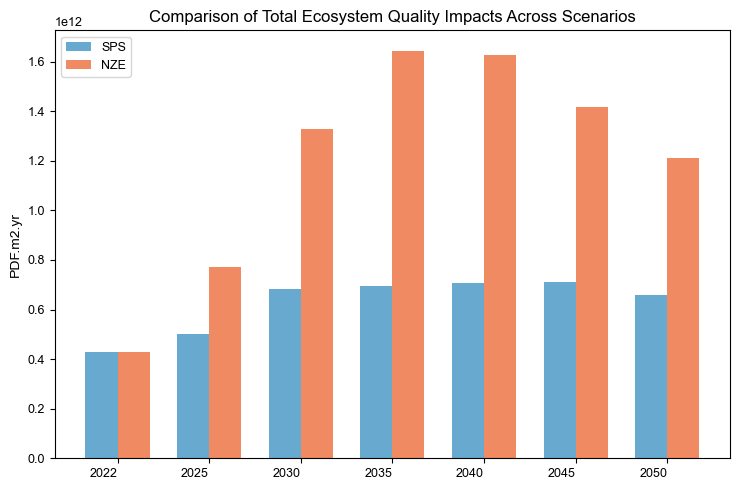

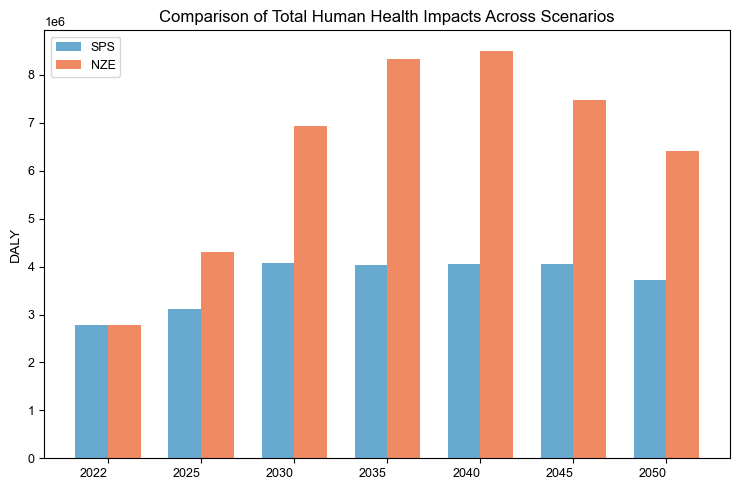

In [58]:
# Plot Total Ecosystem Quality
plot_scenario_comparison(df_sps_damage, df_nze_damage, "Total ecosystem quality",
                         "SPS", "NZE",
                         "Comparison of Total Ecosystem Quality Impacts Across Scenarios",
                         "PDF.m2.yr",
                         colors=("#67a9cf", "#ef8a62"),
                         save_path="results/plots/scenario_comparison/ecosystem_quality")

# Plot Total Human Health
plot_scenario_comparison(df_sps_damage, df_nze_damage, "Total human health",
                         "SPS", "NZE",
                         "Comparison of Total Human Health Impacts Across Scenarios",
                         "DALY",
                         colors=("#67a9cf", "#ef8a62"),
                         save_path="results/plots/scenario_comparison/human_health")


## Sankey

In [65]:
def create_sankey(df, total_col, impact_columns, title, save_path):
    """
    Create a Sankey diagram showing cumulative effects from metals -> technologies -> midpoint indicators.

    Parameters:
    - df: DataFrame with data
    - total_col: Column containing total impact (e.g., 'Total ecosystem quality' or 'Total human health')
    - impact_columns: List of midpoint impact indicators (e.g., EQ or HH categories)
    - title: Title of the Sankey diagram
    - save_path: Path to save the HTML file of the figure

    Outputs:
    - Saves the Sankey diagram as an interactive HTML file and PNG.
    """

    # Ensure directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Sum impacts over all years (2022-2050)
    df_cumulative = df.groupby(["Metal", "Technology"])[impact_columns + [total_col]].sum().reset_index()

    # Get unique categories
    all_metals = df_cumulative["Metal"].unique().tolist()
    all_technologies = df_cumulative["Technology"].unique().tolist()
    all_midpoints = impact_columns

    # Define node labels (Metals, Technologies, Midpoints)
    node_labels = all_metals + all_technologies + all_midpoints
    node_colors = (
        ["#d53e4f"] * len(all_metals) +  # Metals (red shades)
        ["#5ab4ac"] * len(all_technologies) +  # Technologies (blue-green shades)
        ["#3288bd"] * len(all_midpoints)  # Midpoint Indicators (blue shades)
    )

    # Create node dictionary for indexing
    node_dict = {name: i for i, name in enumerate(node_labels)}

    # Initialize link sources, targets, and values
    sources, targets, values = [], [], []

    # Metal -> Technology links
    for _, row in df_cumulative.iterrows():
        metal_idx = node_dict[row["Metal"]]
        tech_idx = node_dict[row["Technology"]]
        total_flow = row[total_col]  # Total impact flow from Metal to Technology
        sources.append(metal_idx)
        targets.append(tech_idx)
        values.append(total_flow)

    # Technology -> Midpoint Indicator links
    for tech in all_technologies:
        for midpoint in all_midpoints:
            tech_idx = node_dict[tech]
            midpoint_idx = node_dict[midpoint]
            total_flow = df_cumulative[df_cumulative["Technology"] == tech][midpoint].sum()
            sources.append(tech_idx)
            targets.append(midpoint_idx)
            values.append(total_flow)
            
    # Define node positions explicitly
    x_positions = (
    [0.1] * len(all_metals) +   # Metals on the left
    [0.5] * len(all_technologies) +  # Technologies in the middle
    [0.9] * len(all_midpoints)  # Midpoint indicators on the far right
)        
            
    # Create Sankey figure
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=1),
            label=node_labels,
            color=node_colors,
            x=x_positions,
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values
        )
    ))

    fig.update_layout(
    title_text=title,
    font_size=12,
    font=dict(family="Arial", size=12, color="black"),
    font_color="black",  # Ensure text remains visible
    width=1200,
    height=700,
    paper_bgcolor="white",  # Set the entire image background to white
    plot_bgcolor="white"  # Set the plot area background to white
)
    # Save as interactive HTML and PNG
    fig.write_html(f"{save_path}.html")
    #fig.write_image(f"{save_path}.pdf")  # High resolution PNG

    return fig

In [66]:
# Define directory for saving Sankey diagrams
sankey_dir = "results/plots/sankey"
os.makedirs(sankey_dir, exist_ok=True)

In [67]:
fig_sankey_sps_eq = create_sankey(df_sps_damage, "Total ecosystem quality", EQ, "Ecosystem Quality Flow", f"{sankey_dir}/sankey_sps_eq")

In [68]:
fig_sankey_sps_hh = create_sankey(df_sps_damage, "Total human health", HH, "Human Health Flow", f"{sankey_dir}/sankey_sps_hh")

In [69]:
fig_sankey_nze_eq = create_sankey(df_nze_damage, "Total ecosystem quality", EQ, "Ecosystem Quality Flow",
                                  f"{sankey_dir}/sankey_nze_eq")

In [70]:
fig_sankey_nze_hh = create_sankey(df_nze_damage, "Total human health", HH, "Human Health Flow",
                                  f"{sankey_dir}/sankey_nze_hh")